Ben Ghertner 2025

Solves for the theoretical dispersion relationships on the semi-infinite and finite domains and plots a set of normal modes for a particular value of $k$ in each domain.

    - Figure 3.4
    - Figure 3.5
    - Figure 3.6
    - Figure 3.7


In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.usetex'] = True
plt.rcParams["font.size"] = 11

%matplotlib inline

Inversion set-up parameters and dispersion + rootfinding methods

In [2]:
#These come from CM1 init3d_BLG.F inversionwave
N2t = 4.19864664E-05
N2i = 3.66779772E-04
N2c = 2.03111340E-04

#Nominal Cloud and Inversion Heights and Domain Top Height
Hc  = 300
Hi  = 600
HT = 1500

#evaluate dispersion relationship (semi-infinite domain) defined by Det(M) with M given in Eq (3.32)
# input:
#       c - wavespeed
#       k - wavenumber
# returns:
#       Det(M) from Eq (3.32)
def dispersion_semiinf(c,k):
    mt = np.sqrt( (k**2 - N2t/c**2) )
    mi = np.sqrt( (N2i/c**2 - k**2) )
    mc = np.sqrt( (k**2 - N2c/c**2) )

    J_psia_Hi = np.sin(mi*Hi)*-mt - mi*np.cos(mi*Hi)
    J_psib_Hi = np.cos(mi*Hi)*-mt + mi*np.sin(mi*Hi)
    J_psia_Hc = mi*np.cos(mi*Hc) - np.sin(mi*Hc)*mc/np.tanh(mc*Hc)
    J_psib_Hc = -mi*np.sin(mi*Hc) - np.cos(mi*Hc)*mc/np.tanh(mc*Hc)

    return J_psia_Hi*J_psib_Hc - J_psib_Hi*J_psia_Hc

#evaluate dispersion relationship (finite domain) defined by Det(M) with M given in Eq (3.44)
# input:
#       c - wavespeed
#       k - wavenumber
# returns:
#       Det(M) from Eq (3.44)
def dispersion_finite(c,k):
    mt = np.sqrt( (k**2 - N2t/c**2) )
    mi = np.sqrt( (N2i/c**2 - k**2) )
    mc = np.sqrt( (k**2 - N2c/c**2) )

    J_psia_Hi = np.sin(mi*Hi)*mt/np.tanh(mt*(Hi-HT)) - mi*np.cos(mi*Hi)
    J_psib_Hi = np.cos(mi*Hi)*mt/np.tanh(mt*(Hi-HT)) + mi*np.sin(mi*Hi)
    J_psia_Hc = mi*np.cos(mi*Hc) - np.sin(mi*Hc)*mc/np.tanh(mc*Hc)
    J_psib_Hc = -mi*np.sin(mi*Hc) - np.cos(mi*Hc)*mc/np.tanh(mc*Hc)

    return J_psia_Hi*J_psib_Hc - J_psib_Hi*J_psia_Hc

#Routine to root find the dispersion relationships
# input:
#       cguess     - current guess at the wavespeed
#       k          - wavenumber
#       dispersion - callable function taking inputs c and k to root find
#                    intended to be either dispersion_semiinf or dispersion_finite
# returns:
#       c          - Numerical solution to the root finding problem Det(M) = 0
def secant_solve(cguess, k, dispersion):
    i = 0
    #initialize first guess
    c0 = cguess - 0.001
    c1 = cguess
    #iterate until tolerance reached
    while np.abs((c0-c1)/c1) > 1e-10:
        #Safety feature if method is not converging
        i += 1
        if i > 100:
            print('failed to converge')
            return
        #Save current best guess
        ctemp = c1
        #Secant step
        c1 = c1 - dispersion(c1,k)*(c1-c0)/(dispersion(c1,k) - dispersion(c0,k))
        #update last guess
        c0 = ctemp
    
    return c1

Compute the cut-off values of $k$ and $c$ for the semi-infinite domain

In [3]:
#Hard code first guesses needs to be somewhat close
#Long wave cut off
k_limit_semiinf = 2*np.pi/6000
c_limit = 6.6 + 0j
#evanescent/wave in cloud cut-off
k_cld_semiinf   = 2*np.pi/1500
c_cld   = 3.0 + 0j

#Long wave cute off is the root of the vertical wavenumber in the top region
calc_mt = lambda k,c: (k**2 - N2t/c**2)

i = 0
#initialize first guess
k0 = k_limit_semiinf*(1.01)
k1 = k_limit_semiinf
while np.abs((k0-k1)/k1) > 1e-8:
    #fail safe for failed convergence
    i += 1
    if i > 100:
        print('failed to converge')
        break
    #save current best guess
    ktemp = k1
    #compute wavespeeds associated with current guess at k
    c0 = secant_solve(c_limit, k0, dispersion_semiinf)
    c1 = secant_solve(c_limit, k1, dispersion_semiinf)
    #If this fails to converge then we just keep the last guess as close enough
    #I think I needed this because of issues with branch cuts on the otherside
    #of the longwave cut off. The finite domain version doesn't have this issue.
    if c1 is None:
        k1 = k0
        break
    #secant step
    k1 = k1 - calc_mt(k1,c1)*(k1-k0)/(calc_mt(k1,c1) - calc_mt(k0,c0))
    #update last guess
    k0 = ktemp

k_limit_semiinf = k1

#evanescent in cloud cut-off is the root of the vertical wavenumber in the cloud
calc_mc = lambda k,c: (k**2 - N2c/c**2)

i = 0
#initialize first guess
k0 = k_cld_semiinf*(1.01)
k1 = k_cld_semiinf
while np.abs((k0-k1)/k1) > 1e-8:
    #fail safe for failed convergence
    i += 1
    if i > 100:
        print('failed to converge')
        break
    #save current best guess
    ktemp = k1
    #compute wavespeeds associated with current guess at k
    c0 = secant_solve(c_cld, k0, dispersion_semiinf)
    c1 = secant_solve(c_cld, k1, dispersion_semiinf)
    #secant step
    k1 = k1 - calc_mc(k1,c1)*(k1-k0)/(calc_mc(k1,c1) - calc_mc(k0,c0))
    #update last guess
    k0 = ktemp
    
k_cld_semiinf = k1

failed to converge


Compute the cut-off values of $k$ and $c$ for the finite domain

In [4]:
#Hard code first guesses needs to be somewhat close
#Long wave cut off
k_limit_finite = 2*np.pi/5000
c_limit = 5.6 + 0j
#evanescent/wave in cloud cut-off
k_cld_finite   = 2*np.pi/1500
c_cld   = 3.0 + 0j

#Long wave cute off is the root of the vertical wavenumber in the top region
calc_mt = lambda k,c: (k**2 - N2t/c**2)

i = 0
#initialize first guess
k0 = k_limit_finite*(1.01)
k1 = k_limit_finite
while np.abs((k0-k1)/k1) > 1e-8:
    #fail safe for failed convergence
    i += 1
    if i > 100:
        print('failed to converge')
        break
    #save current best guess
    ktemp = k1
    #compute wavespeeds associated with current guess at k
    c0 = secant_solve(c_limit, k0, dispersion_finite)
    c1 = secant_solve(c_limit, k1, dispersion_finite)
    #secant step
    k1 = k1 - calc_mt(k1,c1)*(k1-k0)/(calc_mt(k1,c1) - calc_mt(k0,c0))
    #update last guess
    k0 = ktemp

k_limit_finite = k1

#evanescent in cloud cut-off is the root of the vertical wavenumber in the cloud
calc_mc = lambda k,c: (k**2 - N2c/c**2)

i = 0
#initialize first guess
k0 = k_cld_finite*(1.01)
k1 = k_cld_finite
while np.abs((k0-k1)/k1) > 1e-8:
    #fail safe for failed convergence
    i += 1
    if i > 100:
        print('failed to converge')
        break
    #save current best guess
    ktemp = k1
    #compute wavespeeds associated with current guess at k
    c0 = secant_solve(c_cld, k0, dispersion_finite)
    c1 = secant_solve(c_cld, k1, dispersion_finite)
    #secant step
    k1 = k1 - calc_mc(k1,c1)*(k1-k0)/(calc_mc(k1,c1) - calc_mc(k0,c0))
    #update last guess
    k0 = ktemp
    
k_cld_finite = k1

Compute the dispersion relationship for the semi-infinite domain and plot

**Figure 3.5**

/Users/benjaminghertner/opt/anaconda3/envs/envPython3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/benjaminghertner/opt/anaconda3/envs/envPython3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


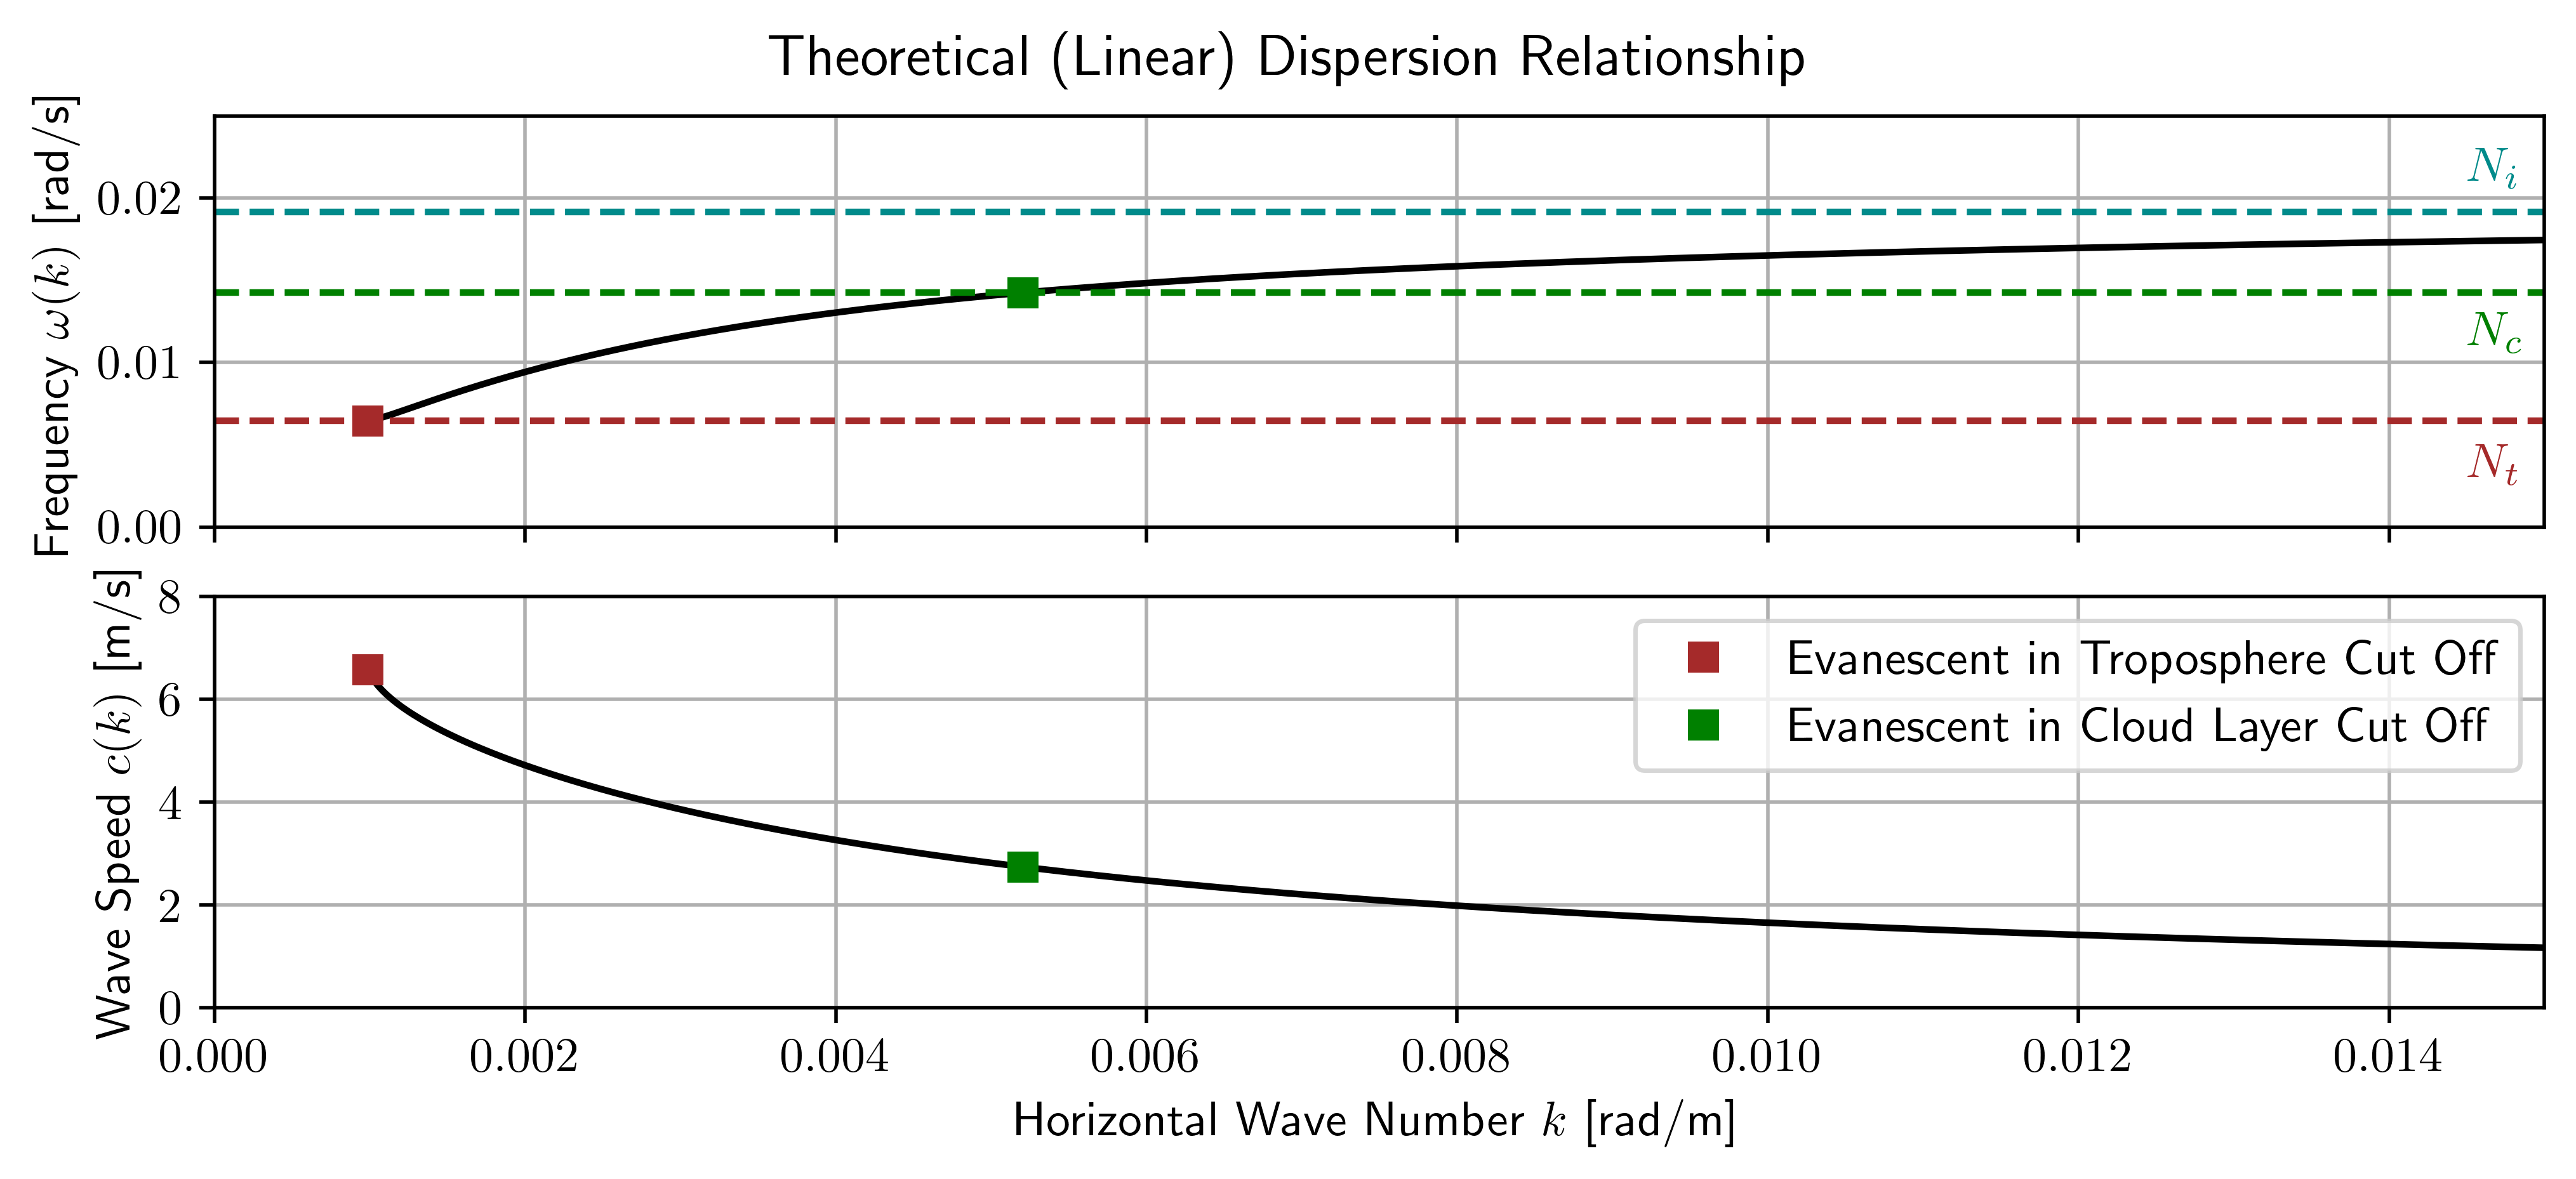

In [5]:
#Initialize arrays for wavenumber and wavespeed
ks_semiinf = np.linspace(k_limit_semiinf, 2*np.pi/250, num=1000)
cs_semiinf = np.empty_like(ks_semiinf)

#Iterate through wavenumbers and compute wavespeed
for idx in range(ks_semiinf.size):
    k = ks_semiinf[idx]
    if idx == 0: c_guess = 6.6+0.0j
    else:        c_guess = cs_semiinf[idx-1]
    cs_semiinf[idx] = secant_solve(c_guess+0j, k, dispersion_semiinf).real

#Plotting
fig, axes = plt.subplots(layout='constrained', nrows=2, sharex=True)
fig.set_size_inches(8, 3.6)
fig.set_dpi(500)

axes[0].plot(ks_semiinf, cs_semiinf*ks_semiinf, color='k')
axes[0].plot(k_limit_semiinf, secant_solve(6.6+0.0j, k_limit_semiinf, dispersion_semiinf)*k_limit_semiinf, 
             's', color='brown', label='Evanescent in Troposphere Cut Off')
axes[0].plot(k_cld_semiinf, secant_solve(2.5+0.0j, k_cld_semiinf, dispersion_semiinf)*k_cld_semiinf, 
             'sg', label='Evanescent in Cloud Layer Cut Off')
axes[0].grid()
axes[0].axhline(np.sqrt(N2t), color='brown', linestyle='dashed')
axes[0].axhline(np.sqrt(N2i), color='darkcyan', linestyle='dashed')
axes[0].axhline(np.sqrt(N2c), color='g', linestyle='dashed')
axes[0].annotate(r'$N_t$', (0.0145, 0.003), color='brown')
axes[0].annotate(r'$N_i$', (0.0145, 0.021), color='darkcyan')
axes[0].annotate(r'$N_c$', (0.0145, 0.011), color='green')
axes[0].set(ylim=(0.0, 0.025))
axes[0].set(ylabel=r'Frequency $\omega(k)$ [rad/s]')

axes[1].plot(ks_semiinf, cs_semiinf, color='k')
axes[1].plot(k_limit_semiinf, secant_solve(6.6+0.0j, k_limit_semiinf, dispersion_semiinf), 
             's', color='brown', label='Evanescent in Troposphere Cut Off')
axes[1].plot(k_cld_semiinf, secant_solve(2.5+0.0j, k_cld_semiinf, dispersion_semiinf), 
             'sg', label='Evanescent in Cloud Layer Cut Off')
axes[1].grid()
axes[1].legend()
axes[1].set(xlim=(0.0, 0.015), ylim=(0.0, 8.))
axes[1].set(xlabel=r'Horizontal Wave Number $k$ [rad/m]', ylabel=r'Wave Speed $c(k)$ [m/s]')

fig.suptitle(r'Theoretical (Linear) Dispersion Relationship')

plt.show()

Compute the dispersion relationship for the semi-infinite domain and plot

**Figure 3.6**

/Users/benjaminghertner/opt/anaconda3/envs/envPython3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/benjaminghertner/opt/anaconda3/envs/envPython3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


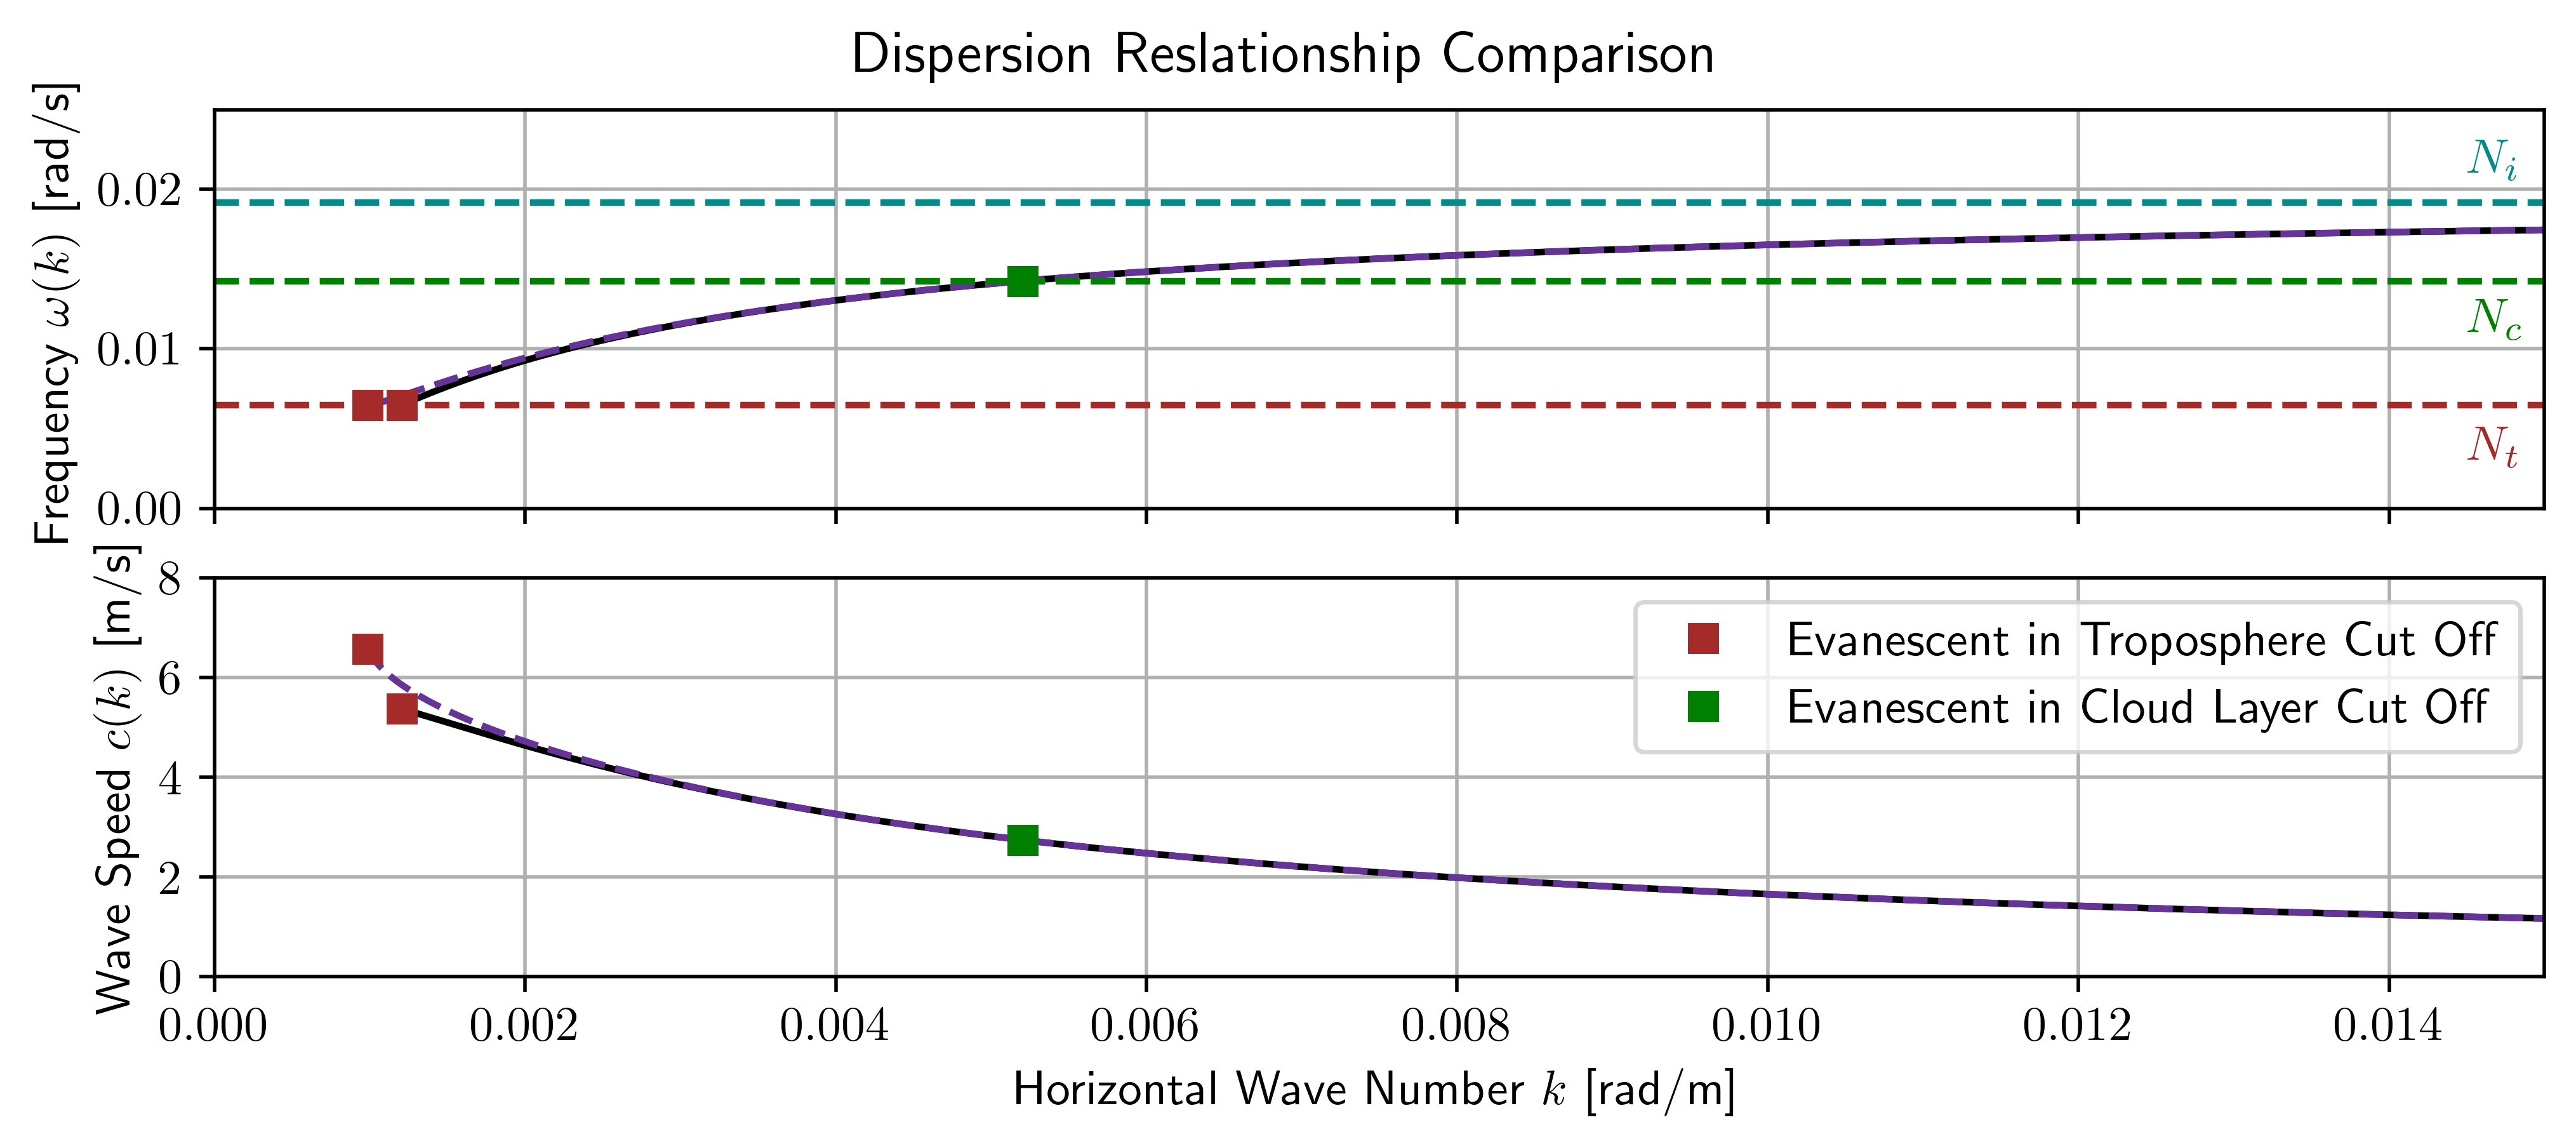

In [6]:
#Initialize arrays for wavenumber and wavespeed
ks_finite = np.linspace(k_limit_finite, 2*np.pi/250, num=1000)
cs_finite = np.empty_like(ks_finite)

#Iterate through wavenumbers and compute wavespeed
for idx in range(ks_finite.size):
    k = ks_finite[idx]
    if idx == 0: c_guess = 5.7+0.0j
    else:        c_guess = cs_finite[idx-1]
    cs_finite[idx] = secant_solve(c_guess+0j, k, dispersion_finite).real

#Plotting
fig, axes = plt.subplots(layout='constrained', nrows=2, sharex=True)
fig.set_size_inches(8, 3.5)
fig.set_dpi(500)

axes[0].plot(ks_finite, cs_finite*ks_finite, color='k')
axes[0].plot(ks_semiinf, cs_semiinf*ks_semiinf, '--', color='rebeccapurple')
axes[0].plot(k_limit_finite, secant_solve(5.7+0.0j, k_limit_finite, dispersion_finite)*k_limit_finite, 
             's', color='brown', label='Evanescent in Troposphere Cut Off')
axes[0].plot(k_cld_finite, secant_solve(2.5+0.0j, k_cld_finite, dispersion_finite)*k_cld_semiinf, 
             'sg', label='Evanescent in Cloud Layer Cut Off')
axes[0].plot(k_limit_semiinf, secant_solve(6.6+0.0j, k_limit_semiinf, dispersion_semiinf)*k_limit_semiinf, 
             's', color='brown', label='Evanescent in Troposphere Cut Off')
axes[0].plot(k_cld_semiinf, secant_solve(2.5+0.0j, k_cld_semiinf, dispersion_semiinf)*k_cld_semiinf, 
             'sg', label='Evanescent in Cloud Layer Cut Off')
axes[0].grid()
axes[0].axhline(np.sqrt(N2t), color='brown', linestyle='dashed')
axes[0].axhline(np.sqrt(N2i), color='darkcyan', linestyle='dashed')
axes[0].axhline(np.sqrt(N2c), color='g', linestyle='dashed')
axes[0].annotate(r'$N_t$', (0.0145, 0.003), color='brown')
axes[0].annotate(r'$N_i$', (0.0145, 0.021), color='darkcyan')
axes[0].annotate(r'$N_c$', (0.0145, 0.011), color='green')
axes[0].set(ylim=(0.0, 0.025))
axes[0].set(ylabel=r'Frequency $\omega(k)$ [rad/s]')

axes[1].plot(ks_finite, cs_finite, color='k')
axes[1].plot(ks_semiinf, cs_semiinf, '--', color='rebeccapurple')
axes[1].plot(k_limit_finite, secant_solve(5.7+0.0j, k_limit_finite, dispersion_finite), 
             's', color='brown')
axes[1].plot(k_cld_finite, secant_solve(2.5+0.0j, k_cld_finite, dispersion_finite), 
             'sg')
axes[1].plot(k_limit_semiinf, secant_solve(6.6+0.0j, k_limit_semiinf, dispersion_semiinf), 
             's', color='brown', label='Evanescent in Troposphere Cut Off')
axes[1].plot(k_cld_semiinf, secant_solve(2.5+0.0j, k_cld_semiinf, dispersion_semiinf), 
             'sg', label='Evanescent in Cloud Layer Cut Off')
axes[1].grid()
axes[1].legend()
axes[1].set(xlim=(0.0, 0.015), ylim=(0.0, 8.))
axes[1].set(xlabel=r'Horizontal Wave Number $k$ [rad/m]', ylabel=r'Wave Speed $c(k)$ [m/s]')

fig.suptitle(r'Dispersion Reslationship Comparison')

plt.show()

**Figure 3.4** (just semi-infinite domain)

lambda1 = -1.0e-17 (This needs to be 0 (numerically) or you have the wrong eigenvector)


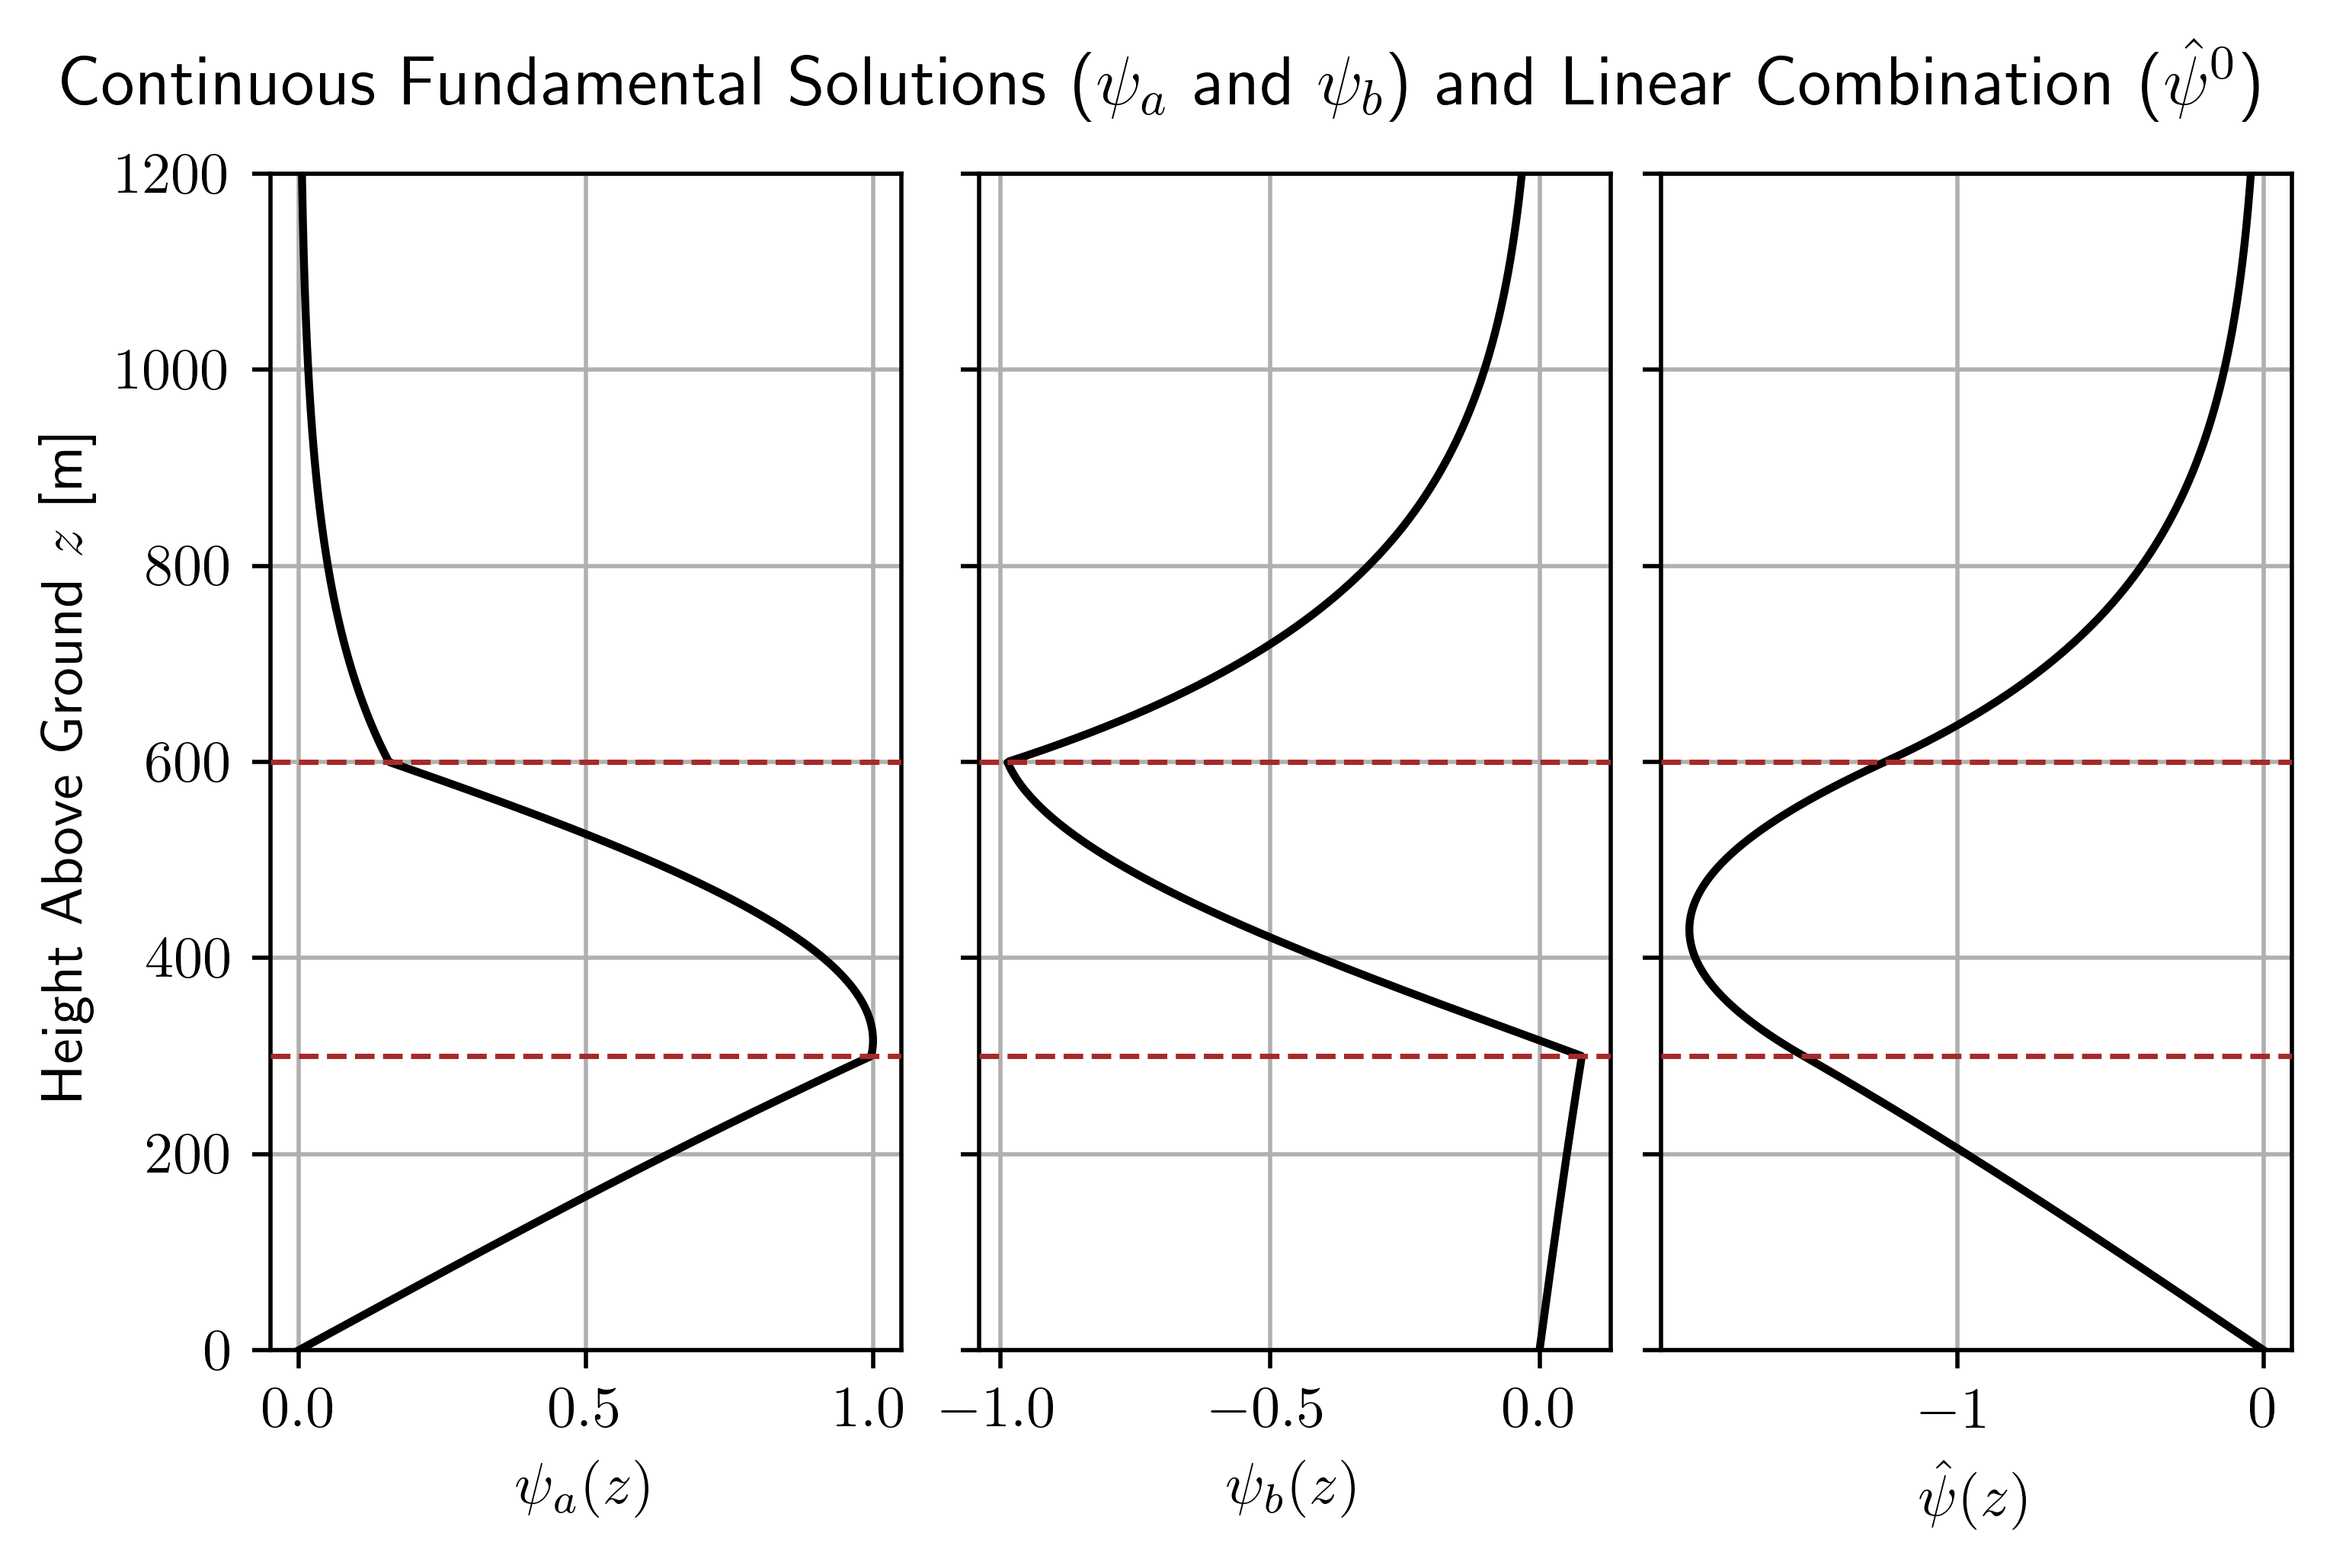

In [7]:
#Choose specific wavenumber
k0  = 2*np.pi/1000
#Compute frequency associated
om0si = secant_solve(2.4+0j, k0, dispersion_semiinf).real*k0

#Veritical wavenumbers
mtsi = k0*np.sqrt( (1 - N2t/om0si**2) )
misi = k0*np.sqrt( (N2i/om0si**2 - 1) )
mcsi = k0*np.sqrt( (1 - N2c/om0si**2) )

#Continuous fundamental solutions Eq (3.30)
psiasi = lambda z: np.where(z > Hi, np.sin(misi*Hi)*np.exp(mtsi*(Hi - z)),
                 np.where(z > Hc, np.sin(misi*z),
                                  np.sin(misi*Hc)*np.sinh(mcsi*z)/np.sinh(mcsi*Hc)))
psibsi = lambda z: np.where(z > Hi, np.cos(misi*Hi)*np.exp(mtsi*(Hi - z)),
                 np.where(z > Hc, np.cos(misi*z),
                                  np.cos(misi*Hc)*np.sinh(mcsi*z)/np.sinh(mcsi*Hc)))

#Matrix elements as in Eq (3.32)
asi = np.sin(misi*Hi)*-mtsi - misi*np.cos(misi*Hi)
bsi = np.cos(misi*Hi)*-mtsi + misi*np.sin(misi*Hi)
csi = misi*np.cos(misi*Hc) - np.sin(misi*Hc)*mcsi/np.tanh(mcsi*Hc)
dsi = -misi*np.sin(misi*Hc) - np.cos(misi*Hc)*mcsi/np.tanh(mcsi*Hc)

#Check you have the zero eigenvector
print(f'lambda1 = {(1/2)*(np.sqrt((asi - dsi)**2 + 4*bsi*csi) + asi + dsi):.1e} (This needs to be 0 (numerically) or you have the wrong eigenvector)')

#Zero eigenvector
v1si = [
    (asi - dsi + np.sqrt((asi - dsi)**2 + 4*bsi*csi))/(2*csi),
    1
]

#Continuous + continuous derivative normal mode
psih0si = lambda z: v1si[0]*psiasi(z) + v1si[1]*psibsi(z)

#Vertical grid
zz = np.linspace(0.01, 1200., num=1000)

#Plotting
fig, axes = plt.subplots(layout='constrained', ncols=3, sharey=True)
fig.set_size_inches(6, 4.0)
fig.set_dpi(500)

axes[0].plot(psiasi(zz), zz, color='k', zorder=3)
axes[0].grid()
axes[0].set(ylim=(0, 1200))
axes[0].axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[0].axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[0].set(xlabel=r'$\psi_a(z)$', ylabel=r'Height Above Ground $z$ [m]')

axes[1].plot(psibsi(zz), zz, color='k', zorder=3)
axes[1].grid()
axes[1].axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[1].axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[1].set(xlabel=r'$\psi_b(z)$')

axes[2].plot(psih0si(zz), zz, color='k', zorder=3)
axes[2].grid()
axes[2].axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[2].axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[2].set(xlabel=r'$\hat\psi(z)$')

fig.suptitle(r'Continuous Fundamental Solutions ($\psi_a$ and $\psi_b$)'+''+r' and Linear Combination ($\hat\psi^0$)')

plt.show()

**Figure 3.7** (Finite and semi-infinite domains)

lambda1 = 4.3e-18 (This needs to be 0 (numerically) or you have the wrong eigenvector)


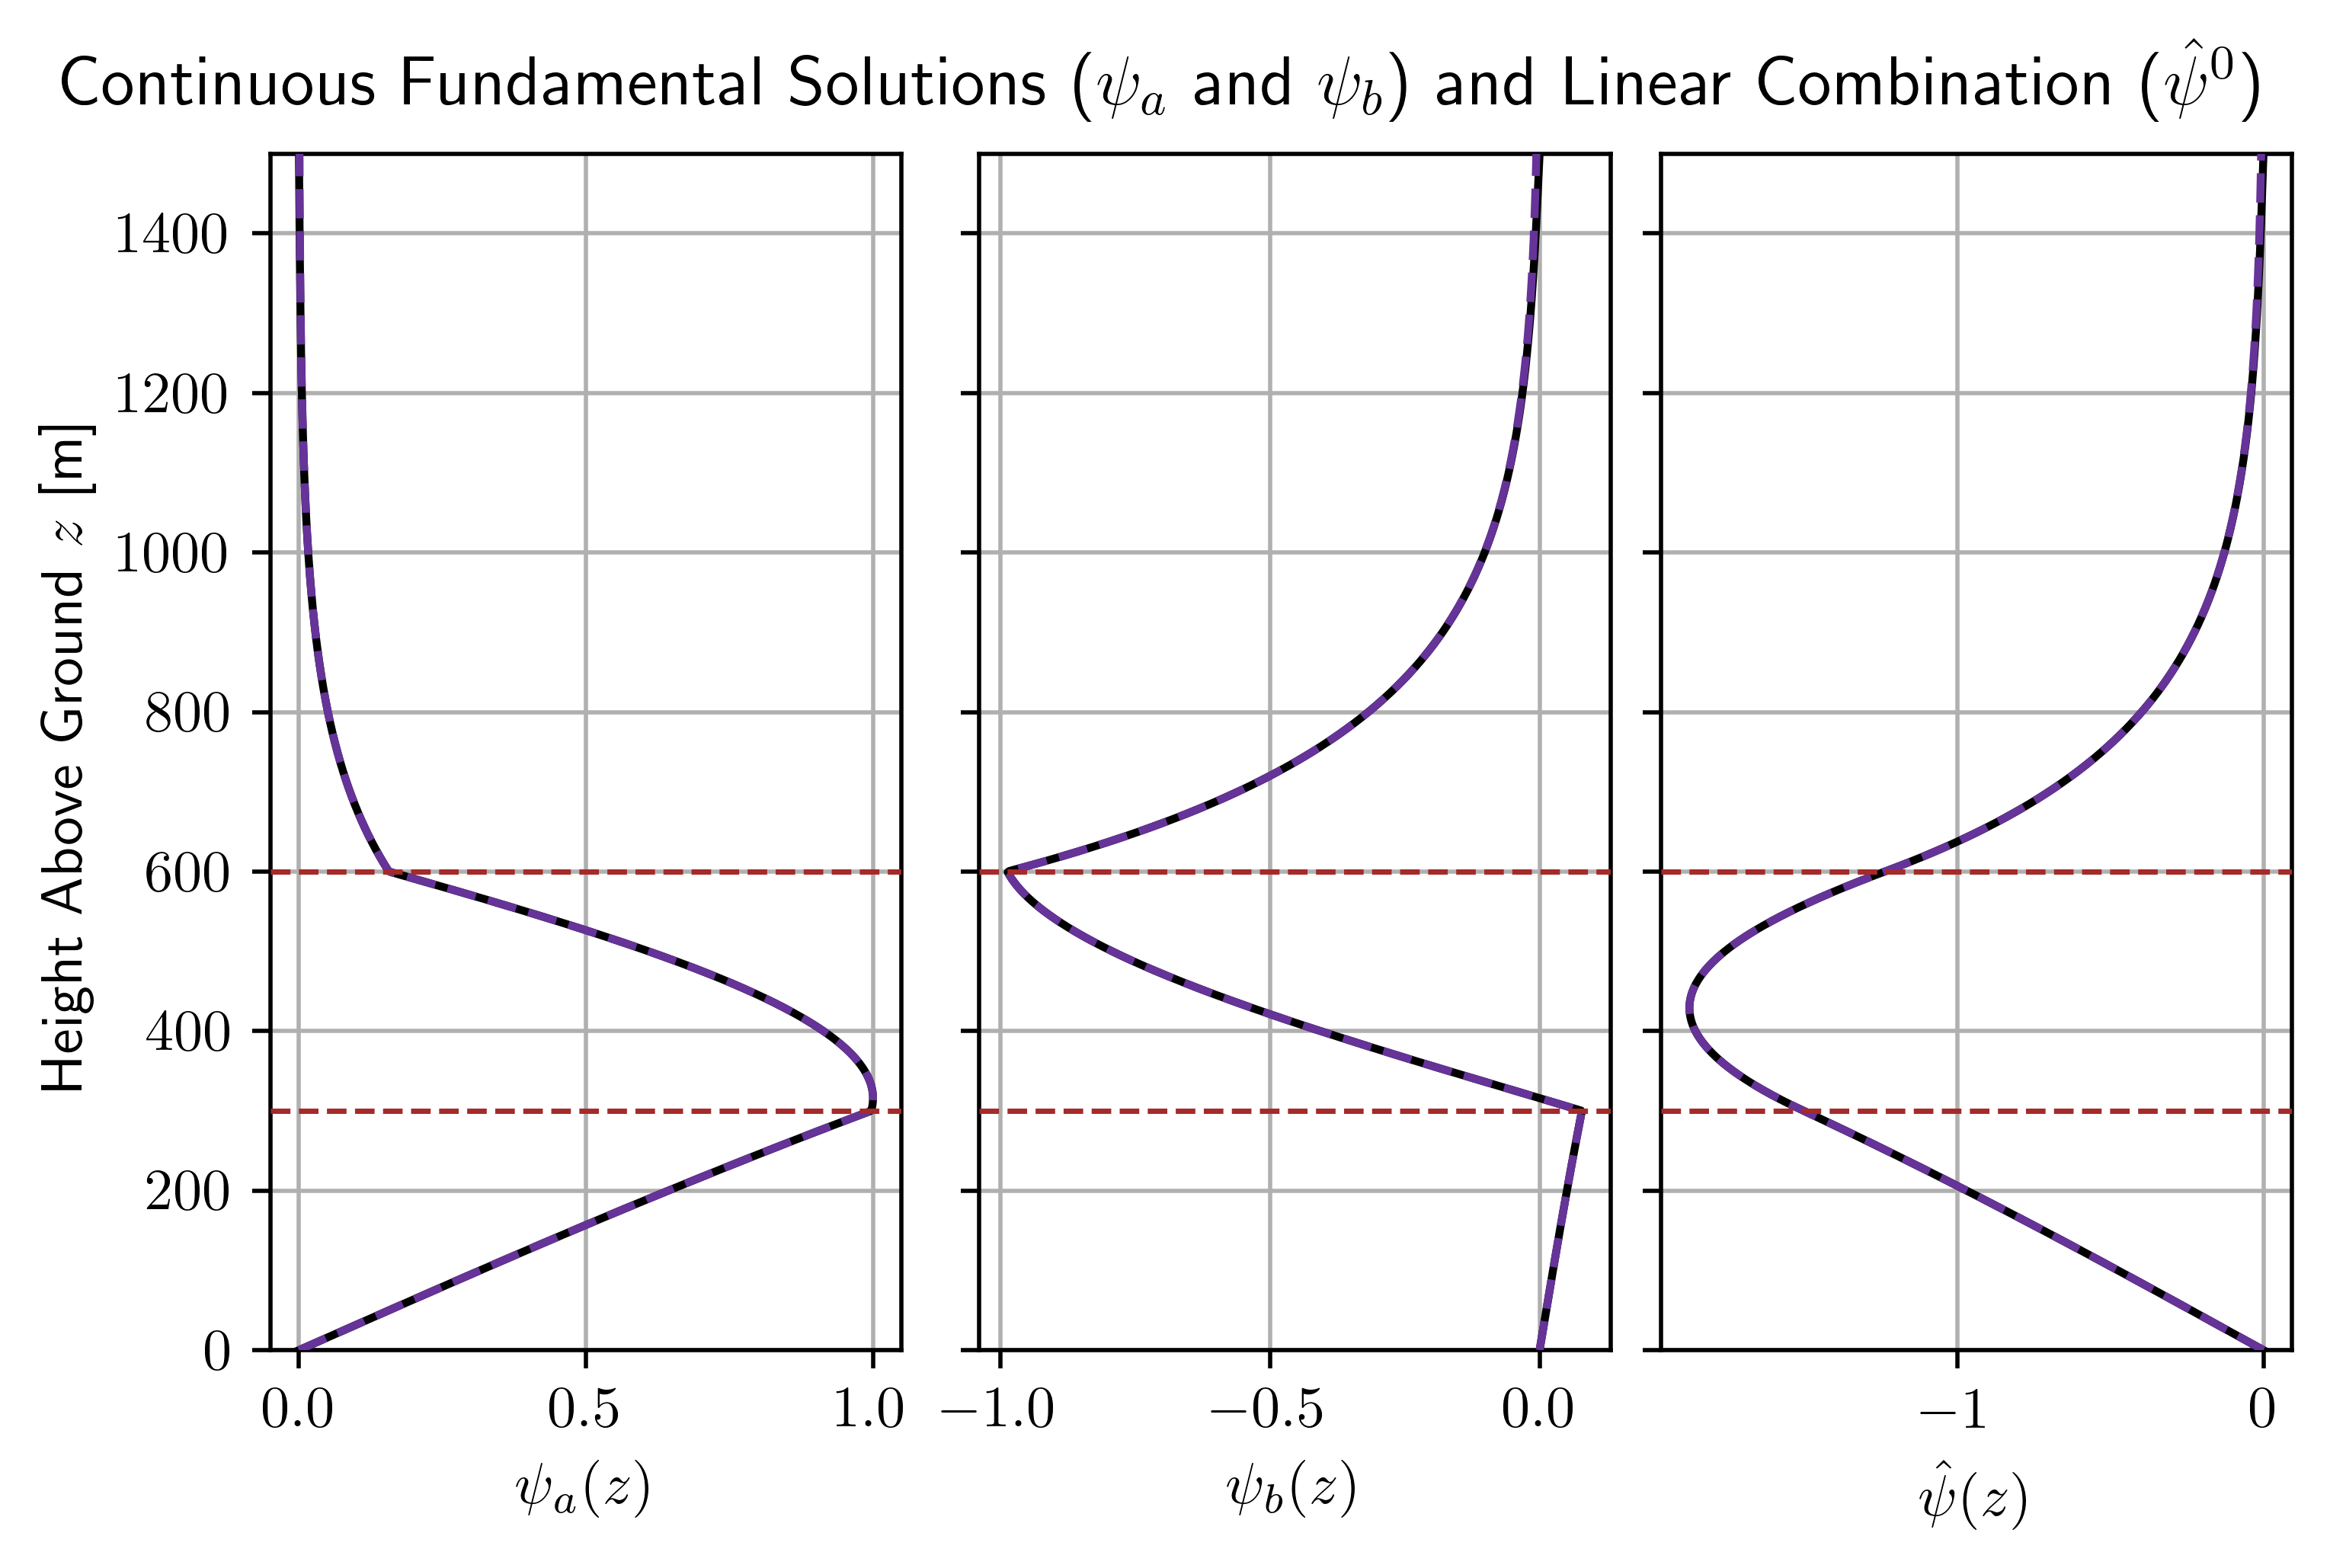

In [8]:
#Frequency associated with particular wavenumber
om0 = secant_solve(2.4+0j, k0, dispersion_finite).real*k0

#Vertical wavenumbers
mt = k0*np.sqrt( (1 - N2t/om0**2) )
mi = k0*np.sqrt( (N2i/om0**2 - 1) )
mc = k0*np.sqrt( (1 - N2c/om0**2) )

#Continuous fundamental solutions Eq (3.43)
psia = lambda z: np.where(z > Hi, np.sin(mi*Hi)*np.sinh(mt*(z - HT))/np.sinh(mt*(Hi-HT)),
                 np.where(z > Hc, np.sin(mi*z),
                                  np.sin(mi*Hc)*np.sinh(mc*z)/np.sinh(mc*Hc)))
psib = lambda z: np.where(z > Hi, np.cos(mi*Hi)*np.sinh(mt*(z - HT))/np.sinh(mt*(Hi-HT)),
                 np.where(z > Hc, np.cos(mi*z),
                                  np.cos(mi*Hc)*np.sinh(mc*z)/np.sinh(mc*Hc)))

#Matrix elements Eq (3.44)
a = np.sin(mi*Hi)*mt/np.tanh(mt*(Hi-HT)) - mi*np.cos(mi*Hi)
b = np.cos(mi*Hi)*mt/np.tanh(mt*(Hi-HT)) + mi*np.sin(mi*Hi)
c = mi*np.cos(mi*Hc) - np.sin(mi*Hc)*mc/np.tanh(mc*Hc)
d = -mi*np.sin(mi*Hc) - np.cos(mi*Hc)*mc/np.tanh(mc*Hc)

#Check you have the zero eigenvector
print(f'lambda1 = {(1/2)*(np.sqrt((a - d)**2 + 4*b*c) + a + d):.1e} (This needs to be 0 (numerically) or you have the wrong eigenvector)')

#Zero eiegenvector
v1 = [
    (a - d + np.sqrt((a - d)**2 + 4*b*c))/(2*c),
    1
]

#Continuous + continuous derivative normal mode
psih0 = lambda z: v1[0]*psia(z) + v1[1]*psib(z)

#vertical grid
zz = np.linspace(0.01, 1500., num=1000)

#plotting
fig, axes = plt.subplots(layout='constrained', ncols=3, sharey=True)
fig.set_size_inches(6, 4.0)
fig.set_dpi(500)

axes[0].plot(psia(zz), zz, color='k', zorder=3)
axes[0].grid()
axes[0].set(ylim=(0, 1500))
axes[0].axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[0].axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[0].set(xlabel=r'$\psi_a(z)$', ylabel=r'Height Above Ground $z$ [m]')

axes[1].plot(psib(zz), zz, color='k', zorder=3)
axes[1].grid()
axes[1].axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[1].axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[1].set(xlabel=r'$\psi_b(z)$')

axes[2].plot(psih0(zz), zz, color='k', zorder=3)
axes[2].grid()
axes[2].axhline(Hc, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[2].axhline(Hi, color='brown', linestyle='dashed', zorder=4, linewidth=1)
axes[2].set(xlabel=r'$\hat\psi(z)$')

fig.suptitle(r'Continuous Fundamental Solutions ($\psi_a$ and $\psi_b$)'+''+r' and Linear Combination ($\hat\psi^0$)')

axes[0].plot(psiasi(zz), zz, color='rebeccapurple', zorder=3, linestyle='--')
axes[1].plot(psibsi(zz), zz, color='rebeccapurple', zorder=3, linestyle='--')
axes[2].plot(psih0si(zz), zz, color='rebeccapurple', zorder=3, linestyle='--')

plt.show()